# NHP1 - Non-human primate data master script (exploratory subject only)

## Takuya Ito
#### 01/07/2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import sys
import h5py
import statsmodels.api as sm
import analysisNHP as analysis


# Set up data parameters

In [3]:
## All sessions (both subjects included)
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing

# Load in monkeyIDs
idfile = datadir + 'monkeyToSessionID.csv'
monkeyTable = pd.read_csv(idfile,delimiter=',')

replication_sessions = 0
monkeyID = {}
for i in range(1, len(sessions)+1):
    if i < 10:
        sess_str = 'session_ ' + str(i)
        name_str = 'name_ '  + str(i)
    else:
        sess_str = 'session_' + str(i)
        name_str = 'name_'  + str(i)
    
    session = str(monkeyTable[sess_str][0])
    name = monkeyTable[name_str][0]

    if name=='paula':
        replication_sessions += 1
        
    if session=='110111_02.mat': session = '110111_02'
        
    monkeyID[session] = name
    
exploratory_sessions = len(sessions) - replication_sessions
print 'Number of sessions with exploratory subject:', exploratory_sessions 
print 'Number of sessions with replication subject', replication_sessions
    
regions = ['PFC', 'FEF', 'LIP', 'MT', 'IT', 'V4']

Number of sessions with exploratory subject: 16
Number of sessions with replication subject 39


# 1.0 Load all sessions for exploratory subject

#### Load other meta-data associated with neurons + task info

#### Compute downsampled firing rate using 50ms bins and 10ms shift

In [5]:
data

,STA_byTask,area,mocolInfo,session,spikesBinned,sta_removed,taskInfo


In [7]:
data = {}
data['area'] = []
data['session'] = []
data['spikesBinned'] = []
data['STA_byTask'] = []
data['taskInfo'] = []
data['mocolInfo'] = []
data['sta_removed'] = []

sessioncount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='rex': continue
    print 'Loading data for session', session, '|', sessioncount, '/', exploratory_sessions 
    
    taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
    mocolTrials = np.where(taskInfo['task']=='mocol')[0]
    mocolInfo = pd.read_csv(datadir + session + '_trialInfoMOCOL.csv')
    areas = pd.read_csv(datadir + session + '_areaIndices.csv')

    h5f = h5py.File(datadir + session + '_perArea.h5', 'r')
    for i in range(len(areas)):
        # Columns for h5f are reversed between matlab and python
        data['area'].append(areas['Var1'][i])
        data['session'].append(session)
        spikes_binned = analysis.slidingWindow(h5f['sta'][mocolTrials,:,i].T,binSize=50,shiftSize=10)
        
        # Calculate mean-evoked response, and remove it from each trial
        sta_removed = np.zeros(spikes_binned.shape)
        tasksByTrial = mocolInfo['rule'].astype(str)
        staByTask = {}
        for task in np.unique(tasksByTrial):
            task_ind = np.where(tasksByTrial==task)[0]
            staByTask[task] = np.mean(spikes_binned[:,task_ind],axis=1)
            for ind in task_ind:
                sta_removed[:,ind] = spikes_binned[:,ind] - staByTask[task]
            
        data['spikesBinned'].append(spikes_binned)
        data['sta_removed'].append(sta_removed)
        
        tasksByTrial = mocolInfo['rule'].astype(str)
        staByTask = {}
        for task in np.unique(tasksByTrial):
            task_ind = np.where(tasksByTrial==task)[0]
            staByTask[task] = np.mean(spikes_binned[:,task_ind],axis=1)
        data['STA_byTask'].append(staByTask)
        data['taskInfo'].append(taskInfo)
        data['mocolInfo'].append(mocolInfo)
    h5f.close()
    
    sessioncount += 1
    
data = pd.DataFrame(data)


Loading data for session 100706 | 1 / 16
Loading data for session 100730 | 2 / 16
Loading data for session 100804 | 3 / 16
Loading data for session 100820 | 4 / 16
Loading data for session 100827 | 5 / 16


(array([ 102.,  267.,  370.,  164.,   65.,   31.,   25.,   18.,   10.,
          12.,   10.,   11.,    5.,    8.,    1.,    5.,    3.,    1.,
           3.,    1.,    1.,    0.,    4.,    2.,    1.,    1.,    2.,
           3.,    1.,    1.,    0.,    1.,    1.,    4.,    1.,    1.,
           0.,    1.,    3.,    0.,    1.,    3.,    0.,    0.,    1.,
           2.,    0.,    1.,    0.,    2.]),
 array([ 0.709925,  0.889521,  1.069117,  1.248713,  1.428309,  1.607905,
         1.787501,  1.967097,  2.146693,  2.326289,  2.505885,  2.685481,
         2.865077,  3.044673,  3.224269,  3.403865,  3.583461,  3.763057,
         3.942653,  4.122249,  4.301845,  4.481441,  4.661037,  4.840633,
         5.020229,  5.199825,  5.379421,  5.559017,  5.738613,  5.918209,
         6.097805,  6.277401,  6.456997,  6.636593,  6.816189,  6.995785,
         7.175381,  7.354977,  7.534573,  7.714169,  7.893765,  8.073361,
         8.252957,  8.432553,  8.612149,  8.791745,  8.971341,  9.150937,
        

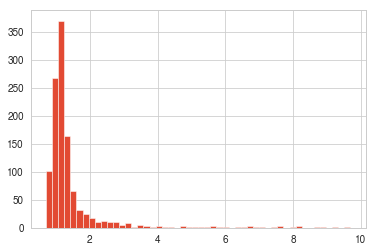

In [28]:
plt.hist(data['mocolInfo'][0]['cueOn'] - data['mocolInfo'][0]['fixptOn'],bins=50)

# Perform main analyses for exploratory subject

In [4]:
analysis = reload(analysis)

In [5]:
dimReplications = {}
dimReplications['avg_post'] = []
dimReplications['avg_pre'] = []

spkCorrReplications = {}
spkCorrReplications['avg_post'] = []
spkCorrReplications['avg_pre'] = []

sdReplications = {}
sdReplications['avg_post'] = []
sdReplications['avg_pre'] = []

frReplications = {}
frReplications['avg_post'] = []
frReplications['avg_pre'] = []


totalDims = []
totalSpkCorr = []
totalSD = []
totalFR = []
    
sesscount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='rex': continue
    print 'Computing statistics for session', session, '|', sesscount, '/', exploratory_sessions 
    df = data.loc[data['session']==session]
    sta_removed = analysis.concatenateTS(df)
    tmp1, tmp2, tmp3, tmp4 = analysis.computeStatistics(df,sta_removed)

    dimReplications['avg_post'].extend(tmp1['avg_post'])
    dimReplications['avg_pre'].extend(tmp1['avg_pre'])

    for trial in range(tmp2['avg_post'].shape[2]):
        spkCorrReplications['avg_post'].append(tmp2['avg_post'][:,:,trial])
        spkCorrReplications['avg_pre'].append(tmp2['avg_pre'][:,:,trial])

    sdReplications['avg_post'].extend(tmp3['avg_post'].T)
    sdReplications['avg_pre'].extend(tmp3['avg_pre'].T)

    frReplications['avg_post'].extend(tmp4['avg_post'].T)
    frReplications['avg_pre'].extend(tmp4['avg_pre'].T)

    sesscount += 1

Computing statistics for session 100913 | 1 / 16
Computing statistics for session 100921 | 2 / 16
Computing statistics for session 101024 | 3 / 16
Computing statistics for session 100915 | 4 / 16
Computing statistics for session 101008 | 5 / 16
Computing statistics for session 101027 | 6 / 16
Computing statistics for session 110120 | 7 / 16
Computing statistics for session 100907 | 8 / 16
Computing statistics for session 100917 | 9 / 16
Computing statistics for session 101009 | 10 / 16
Computing statistics for session 101028 | 11 / 16
Computing statistics for session 110121 | 12 / 16
Computing statistics for session 100910 | 13 / 16
Computing statistics for session 100920 | 14 / 16
Computing statistics for session 101023 | 15 / 16
Computing statistics for session 101030 | 16 / 16


## Compute statistics for exploratory subject

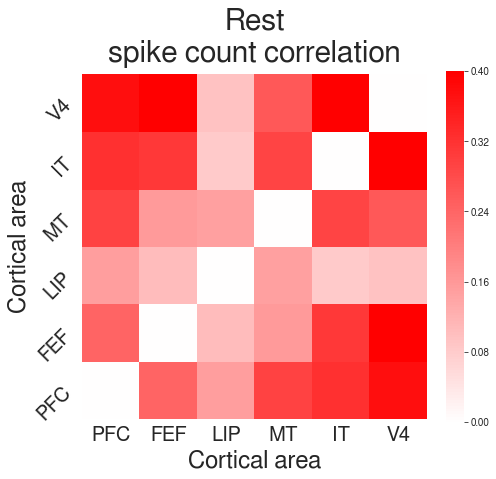

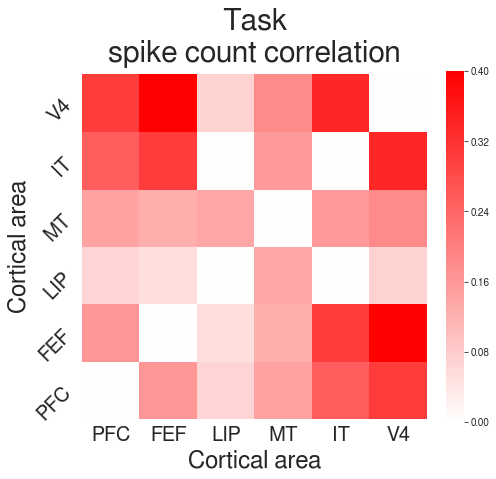

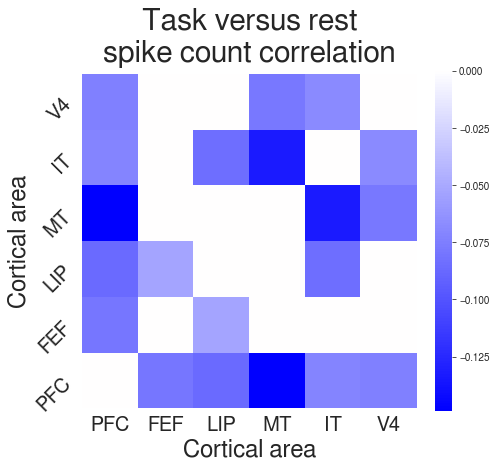

In [6]:
noiseCorrMat = np.zeros((len(regions),len(regions),4)) # corr, t, p, q
prePostCorrMat = np.zeros((len(regions),len(regions),2)) # Pre-stim X post-stim
for i in range(len(regions)):
    for j in range(len(regions)):
        if i == j: continue
        tmp = []
        tmppre = []
        tmppost = []
        for sess in range(len(spkCorrReplications['avg_post'])):
            if spkCorrReplications['avg_post'][sess][i,j]!=0 and spkCorrReplications['avg_pre'][sess][i,j]!=0:
                tmp.append(spkCorrReplications['avg_post'][sess][i,j] - spkCorrReplications['avg_pre'][sess][i,j])
                tmppre.append(spkCorrReplications['avg_pre'][sess][i,j])
                tmppost.append(spkCorrReplications['avg_post'][sess][i,j])
        t, p = stats.ttest_1samp(tmp,0)
        noiseCorrMat[i,j,0] = np.mean(tmp)
        noiseCorrMat[i,j,1] = t
        noiseCorrMat[i,j,2] = p
        
        prePostCorrMat[i,j,0] = np.mean(tmppre)
        prePostCorrMat[i,j,1] = np.mean(tmppost)
        
triu_ind = np.triu_indices(noiseCorrMat.shape[0],k=1)
qs = mc.fdrcorrection0(noiseCorrMat[:,:,2][triu_ind])[0]
noiseCorrMat[:,:,3][triu_ind] = qs
noiseCorrMat[:,:,3] = noiseCorrMat[:,:,3] + noiseCorrMat[:,:,3].T

plt.figure(figsize=(7,7))
ax = sns.heatmap(prePostCorrMat[:,:,0],square=True,center=0,vmin=0, vmax=.4,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Rest\nspike count correlation', fontsize=30,y=1.02)
plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('NHP1_PreStimCorrMat_Exploratory.pdf')

plt.figure(figsize=(7,7))
ax = sns.heatmap(prePostCorrMat[:,:,1],square=True,center=0,vmin=0, vmax=.4,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Task\nspike count correlation', fontsize=30,y=1.02)
plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('NHP1_PostStimCorrMat_Exploratory.pdf')

plt.figure(figsize=(7,7))
sig = np.multiply(noiseCorrMat[:,:,0], noiseCorrMat[:,:,3])
ax = sns.heatmap(sig,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Task versus rest\nspike count correlation', fontsize=30,y=1.02)
plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('NHP1_NoiseCorrMatrix_Exploratory.pdf')

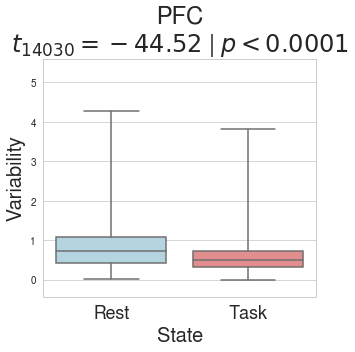

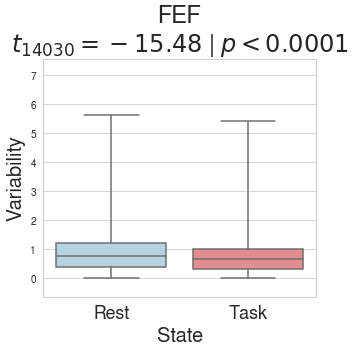

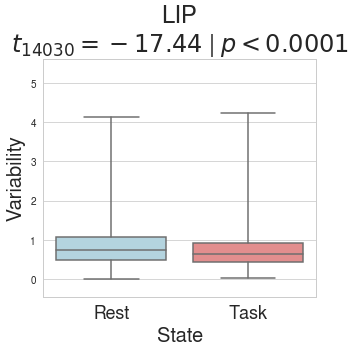

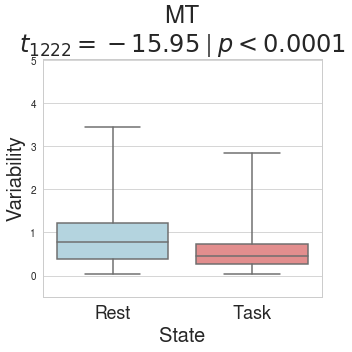

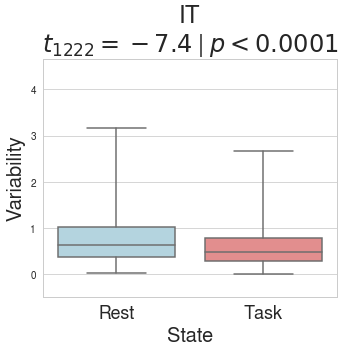

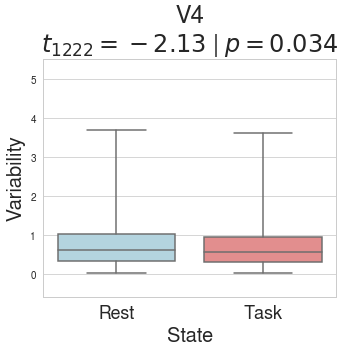

In [7]:
df_sd = {}
ps = []
ts = []
dof = []
for i in range(len(regions)):
    area = regions[i]
    df_sd[area] = {}
    df_sd[area]['Variability'] = []
    df_sd[area]['State'] = []

    tmp = []
    for sess in range(len(sdReplications['avg_post'])):
        if sdReplications['avg_post'][sess][i]!=0 and sdReplications['avg_pre'][sess][i]!=0:
            tmp.append(sdReplications['avg_post'][sess][i] - sdReplications['avg_pre'][sess][i])
            df_sd[area]['Variability'].append(sdReplications['avg_pre'][sess][i])
            df_sd[area]['State'].append('Rest')
            df_sd[area]['Variability'].append(sdReplications['avg_post'][sess][i])
            df_sd[area]['State'].append('Task')
    
    t, p = stats.ttest_1samp(tmp,0)
    ps.append(p)
    ts.append(t)
    dof.append(len(tmp)-1)
qs = mc.fdrcorrection0(ps)[1]
df_sd = pd.DataFrame(df_sd)

for i in range(len(regions)):
    area = regions[i]
    t = ts[i]
    p = qs[i]
    df = dof[i]
    ## Now plot
    plt.figure(figsize=(5,5))
    sns.boxplot(x="State",y='Variability',
               palette=["#add8e6","#f08080"],
               data=df_sd[area],whis=np.inf)
#     sns.stripplot(x="State",y='Variability',
#                palette=["#add8e6","#f08080"],
#                data=df_sd[area], alpha=0.5)

    if p < 0.0001: 
        p = '$p < 0.0001$'
    else:
        p = '$p = ' + str(round(p,3)) + '$'
    plt.title(area + '\n$t_{' + str(df) + '} = ' + str(round(t,2)) + '$ | ' + p,fontname='FreeSans',fontsize=24)
    plt.ylabel('Variability',fontsize=20, fontname='FreeSans')
    plt.xlabel('State', fontsize=20,fontname='FreeSans')
    plt.xticks(fontsize=18,fontname='FreeSans')
    plt.ylim([np.min(df_sd[area]['Variability'])-np.std(df_sd[area]['Variability']),np.max(df_sd[area]['Variability'])+3*np.std(df_sd[area]['Variability'])]);
    plt.tight_layout()
#     plt.savefig('NHP1_' + area + '_spkVariability_Exploratory.pdf')

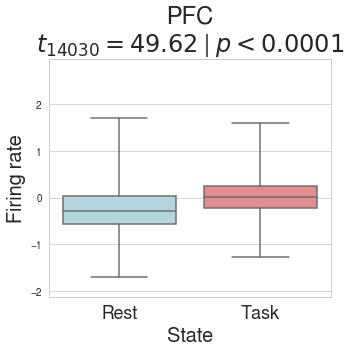

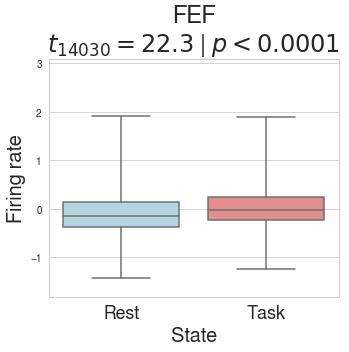

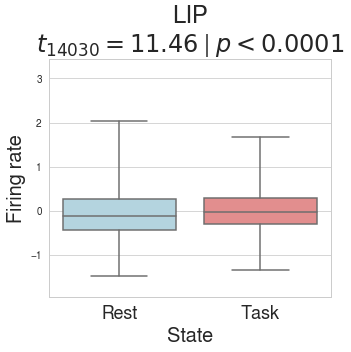

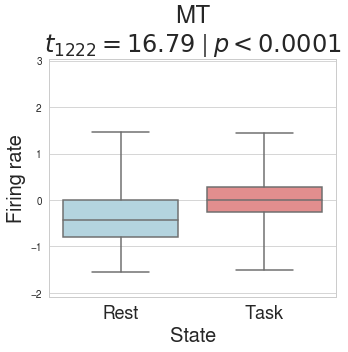

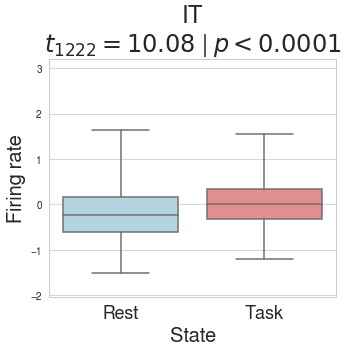

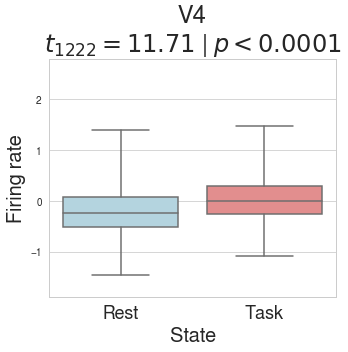

In [8]:
df_fr = {}
ps = []
ts = []
dof = []
for i in range(len(regions)):
    area = regions[i]
    df_fr[area] = {}
    df_fr[area]['Firing rate'] = []
    df_fr[area]['State'] = []

    tmp = []
    for sess in range(len(frReplications['avg_post'])):
        if sdReplications['avg_post'][sess][i]!=0 and sdReplications['avg_pre'][sess][i]!=0:
            tmp.append(frReplications['avg_post'][sess][i] - frReplications['avg_pre'][sess][i])
            df_fr[area]['Firing rate'].append(frReplications['avg_pre'][sess][i])
            df_fr[area]['State'].append('Rest')
            df_fr[area]['Firing rate'].append(frReplications['avg_post'][sess][i])
            df_fr[area]['State'].append('Task')
    
    t, p = stats.ttest_1samp(tmp,0)
    ps.append(p)
    ts.append(t)
    dof.append(len(tmp)-1)
    
qs = mc.fdrcorrection0(ps)[1]
df_fr = pd.DataFrame(df_fr)

for i in range(len(regions)):
    area = regions[i]
    t = ts[i]
    p = qs[i]
    df = dof[i]

    ## Now plot
    plt.figure(figsize=(5,5))
    sns.boxplot(x="State",y='Firing rate',
               palette=["#add8e6","#f08080"],
               data=df_fr[area], whis=np.inf)
#     sns.swarmplot(x="State",y='Firing rate',
#                palette=["#add8e6","#f08080"],
#                data=df_fr[area], alpha=0.5)

    if p < 0.0001: 
        p = '$p < 0.0001$'
    else:
        p = '$p = ' + str(round(p,3)) + '$'
    plt.title(area + '\n$t_{' + str(df) + '} = ' + str(round(t,2)) + '$ | ' + p,fontsize=24)
    plt.ylabel('Firing rate',fontsize=20)
    plt.xlabel('State', fontsize=20)
    plt.xticks(fontsize=18)
    plt.ylim([np.min(df_fr[area]['Firing rate'])-np.std(df_fr[area]['Firing rate']),np.max(df_fr[area]['Firing rate'])+3*np.std(df_fr[area]['Firing rate'])]);
    plt.tight_layout()
#     plt.savefig('NHP1_FR_TaskVRest.pdf')

# Perform global analyses (i.e., averaged across all recordings)

In [9]:
globalSpkCorr = []
globalSD = []
globalFR = []

sesscount = 0
for trial in range(len(sdReplications['avg_pre'])):
    
    tmp_spkCorr = np.zeros((2,))
    tmp_SD = np.zeros((2,))
    tmp_FR = np.zeros((2,))
    
    zero_ind = np.where(sdReplications['avg_post'][trial]!=0)[0]
    
    tmp_SD[0] = np.mean(sdReplications['avg_pre'][trial][zero_ind])
    tmp_SD[1] = np.mean(sdReplications['avg_post'][trial][zero_ind])
    globalSD.append(tmp_SD)
    
    tmp_FR[0] = np.mean(frReplications['avg_pre'][trial][zero_ind])
    tmp_FR[1] = np.mean(frReplications['avg_post'][trial][zero_ind])
    globalFR.append(tmp_FR)
    
    zero_ind.shape = (len(zero_ind),1)
    np.fill_diagonal(spkCorrReplications['avg_pre'][trial],0)
    np.fill_diagonal(spkCorrReplications['avg_post'][trial],0)
    tmp_spkCorr[0] = np.mean(spkCorrReplications['avg_pre'][trial][zero_ind,zero_ind.T])
    tmp_spkCorr[1] = np.mean(spkCorrReplications['avg_post'][trial][zero_ind,zero_ind.T])
    globalSpkCorr.append(tmp_spkCorr)
    
    sesscount += 1
    
globalSpkCorr = np.asarray(globalSpkCorr)
globalSD = np.asarray(globalSD)
globalFR = np.asarray(globalFR)

### Plot

Dimensionality Post- vs. Pre-stim:
Dim diff: 0.158629358287
	t = 32.083 | p = 5.14948307136e-218
SpikeCountCorr Post- vs. Pre-stim:
SpkCorr diff: -0.0481466907648
	t = -23.828 | p = 4.74702244202e-123
SD variability Post- vs. Pre-stim:
SD diff: -0.166556069695
	t = -39.617 | p = 0.0
Firing rate Post- vs. Pre-stim:
FR diff: 0.162546615876
	t = 42.76 | p = 0.0


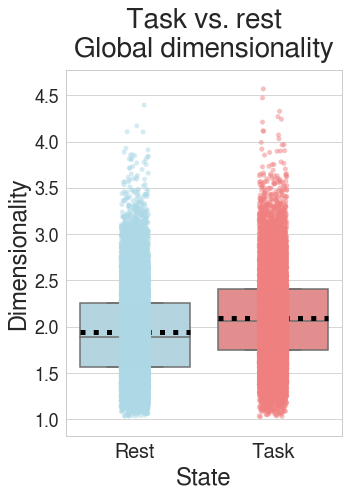

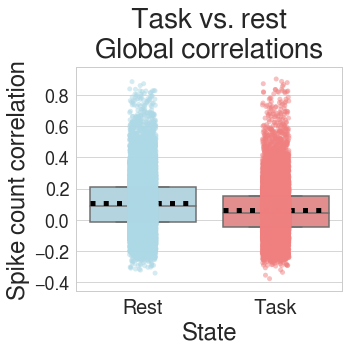

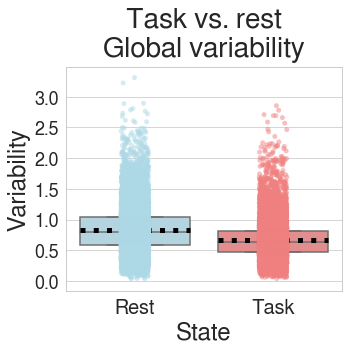

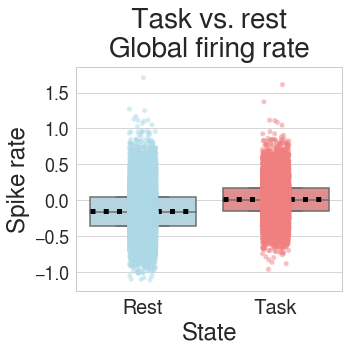

In [10]:
t, p = stats.ttest_rel(dimReplications['avg_post'],dimReplications['avg_pre'])
print 'Dimensionality Post- vs. Pre-stim:'
print 'Dim diff:', np.mean(dimReplications['avg_post']) - np.mean(dimReplications['avg_pre'])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,7))
sns.stripplot(data=[dimReplications['avg_pre'], dimReplications['avg_post']],
           palette=["#add8e6","#f08080"],alpha=0.5)
sns.boxplot(data=[dimReplications['avg_pre'], dimReplications['avg_post']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(dimReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal dimensionality',fontsize=28, y=1.02)
plt.ylabel('Dimensionality',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(dimReplications['avg_post'])-np.std(dimReplications['avg_post']),np.max(dimReplications['avg_post'])+1*np.std(dimReplications['avg_post'])]);
plt.tight_layout()
plt.savefig('NHP1_' + 'globalDim_Replication.pdf')

t, p = stats.ttest_rel(globalSpkCorr[:,1],globalSpkCorr[:,0])
print 'SpikeCountCorr Post- vs. Pre-stim:'
print 'SpkCorr diff:', np.mean(globalSpkCorr[:,1]) - np.mean(globalSpkCorr[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.stripplot(data=[np.tanh(globalSpkCorr[:,0]), np.tanh(globalSpkCorr[:,1])],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[np.tanh(globalSpkCorr[:,0]), np.tanh(globalSpkCorr[:,1])],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(spkCorrReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal correlations',fontsize=28, y=1.02)
plt.ylabel('Spike count correlation',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(globalSpkCorr[:,1])-np.std(globalSpkCorr[:,1]),np.max(globalSpkCorr[:,0])+1*np.std(globalSpkCorr[:,1])]);
plt.tight_layout()
plt.savefig('NHP1_' + 'globalSpkCorr_Replication.pdf')


t, p = stats.ttest_rel(globalSD[:,1],globalSD[:,0])
print 'SD variability Post- vs. Pre-stim:'
print 'SD diff:', np.mean(globalSD[:,1]) - np.mean(globalSD[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.stripplot(data=[globalSD[:,0], globalSD[:,1]],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[globalSD[:,0], globalSD[:,1]],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(spkCorrReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal variability',fontsize=28, y=1.02)
plt.ylabel('Variability',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(globalSD[:,1])-np.std(globalSD[:,1]),np.max(globalSD[:,0])+1*np.std(globalSD[:,0])]);
plt.tight_layout()
plt.savefig('NHP1_' + 'globalVar_Replication.pdf')


t, p = stats.ttest_rel(globalFR[:,1],globalFR[:,0])
print 'Firing rate Post- vs. Pre-stim:'
print 'FR diff:', np.mean(globalFR[:,1]) - np.mean(globalFR[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.stripplot(data=[globalFR[:,0], globalFR[:,1]],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[globalFR[:,0], globalFR[:,1]],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(frReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal firing rate',fontsize=28, y=1.02)
plt.ylabel('Spike rate',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(frReplications['avg_post'])-np.std(frReplications['avg_post']),np.max(frReplications['avg_post'])+1*np.std(frReplications['avg_post'])]);
plt.tight_layout()
plt.savefig('NHP1_' + 'globalFR_Replication.pdf')

